# ResNet50 (A Brief Introduction)

ResNet50 is a convolutional neural network architecture with 50 layers. It is particularly powerful due to the presence of residual connections in its architecture which allows data from one layer to reach later layers by skipping intermediate layers. This eliminates the issue of vanishing gradients which is an issue that prevents a network from learning. This is because the gradient becomes extremely small during backpropagation so the network's weights no longer change.

__The information on ResNet50 was obtained from:__
Kundu N. (23/01/2023), *Exploring ResNet50: An In-Depth Look at the Model Architecture and Code Implementation*, retrieved 10/12/2024 from, https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f

__The information on residual connections was obtained from:__
Wong W. (19/12/2021), *What is Residual Connection?*, retrieved 22/01/2025 from, https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55

__The information on vanishing gradients was obtained from:__
Jacob T. (15/06/2023), *Vanishing Gradient Problem: Causes, Consequences, and Solutions*, retrieved 22/01/2025 from, https://www.kdnuggets.com/2022/02/vanishing-gradient-problem.html#:~:text=During%20back%20propagation%2C%20a%20neural,will%20decrease%20as%20a%20result.

# Import The Relevant Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# This keeps the seed for keras and tensorflow consistent across scripts
from numpy.random import seed 
# keras seed fixing import
seed(1)

# tensorflow seed fixing
tf.random.set_seed(1)

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
import keras_tuner as kt

# Loading and Processing The Data

In [5]:
# Load Data and Make sure It is Divisible By The Batch_Size
def load_and_truncate(data_class, data_fol, batch_size = 32, truncate = 0):
    """
    Loads the data and labels. If the user wants to use a particular
    batch_size for training the data then the data and labels
    may be truncated such that they are divisible by the batch size.

    Parameters
    ----------
    data_class : str
        Whether the data is "Train", "Test" or "Validation"

    data_fol : str
        The folder path of the map arrays and labels.
        
    batch_size : int, default 32
        The batch size you intend to use for the neural network.

    truncate : int, default 0
        If truncate is 1 then the function will truncate your data and labels so that
        its size will be divisible by the batch_size. Otherwise, no truncation will
        occur.

    Returns
    -------
    map_arr : numpy array
        Arrays containing the relevant collection of maps.

    labels : numpy array
        An arrays containing the relevant collection of labels.
    """
    map_arr = np.load(f"{data_fol}/{data_class}/{data_class}_maps.npy")
    labels = np.load(f"{data_fol}/{data_class}/{data_class}_Labels.npy")
    end_pt = len(labels) % batch_size

    if end_pt != 0 and truncate == 1:
        map_arr = map_arr[:-end_pt]
        labels = labels[:-end_pt]

    return map_arr, labels

In [6]:
# Change the data_fol to either "peak_map" or "chi_square_map" or "chi_square_std_peak_maps" depending on which data you wish to classify
data_fol = "chi_square_map"
train, train_labels = load_and_truncate("Train", data_fol)
test, test_labels = load_and_truncate("Test", data_fol)
val, val_labels = load_and_truncate("Validation", data_fol)

In [7]:
# Encode the labels via One Hot Encoding
n_classes = 2
train_labels = to_categorical(train_labels, num_classes=n_classes)
val_labels = to_categorical(val_labels, num_classes=n_classes)
test_labels = to_categorical(test_labels, num_classes=n_classes)

In [8]:
train.shape

(245, 120, 120, 3)

# Implementing The ResNet50 Model

### Tuning The Hyper-Parameters

__The hyper model code was adapted from:__
omalleyt12's response under the thread *How to tune the number of epochs and batch_size?* on (22/10/2019), retrieved on 10/12/2024 from the github discussion forum: https://github.com/keras-team/keras-tuner/issues/122

__The ResNet50 code was adapted from:__
AVERAGEMN (2019) *Keras Binary Cats & Dogs ResNet 98%*, retrieved on 10/12/2024 from: https://www.kaggle.com/code/donkeys/keras-binary-cats-dogs-resnet-98

__The tuner and hyperparameter code was adapted from:__
TensorFlow Keras documentation (16/08/2024) *Introduction to the Keras Tuner*, retrieved on 10/12/2024 from: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [9]:
class MyHyperModel(kt.HyperModel):
    """
    A class representing a Hyper Model which allows for
    keras tuner to identify the best parameters for
    the ResNet model.
    """

    def build(self, hp):
        """
        Builds the ResNet model according
        to a particular set of hyperparameters
    
        Parameters
        ----------
        hp : keras HyperParameters instance
            A HyperParameters Instance which contains the hyperparameters being tested.
    
        Returns
        -------
        resnet_model : keras Sequential model
            A compiled ResNet50 convolutional neural network.
        """
        resnet_model = keras.Sequential()
        
        input_shape = train[0].shape
        pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                           input_shape=input_shape,
                           pooling='avg',classes=n_classes,
                           weights='imagenet')
        
        # Don't train the pretrained layers
        for layer in pretrained_model.layers:
                layer.trainable=False
        
        resnet_model.add(pretrained_model)
        resnet_model.add(Flatten())
        resnet_model.add(Dense(units=hp.Int("units", min_value=32, max_value=512, step=32), activation='relu'))
        # Choose sigmoid activation for binary classification
        resnet_model.add(Dense(n_classes, activation='sigmoid'))
        resnet_model.build((None, input_shape[0], input_shape[1], input_shape[2]))

        # Choose binary crossentropy loss function for binary classification
        resnet_model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),loss='binary_crossentropy',metrics=['binary_accuracy'])
    
        return resnet_model

    def fit(self, hp, resnet_model, *args, **kwargs):
        """
        Fits the given data and hyperparameters to 
        the input resnet_model.

        Parameters
        ----------
        hp : keras HyperParameters instance
            A HyperParameters Instance which contains the hyperparameters being tested.
    
        resnet_model : keras Sequential model
            A compiled ResNet50 convolutional neural network.
    
        Returns
        -------
        fitted resnet model : keras Sequential model
            A compiled ResNet50 convolutional neural network fitted to the given data,
            with a particular set of hyperparameters.
        """
        return resnet_model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64]),
            **kwargs,
        )

In [10]:
def obtain_hyperparams(tuner, validation_data, epochs = 3):
    """
    Obtains the best hyperparameters for a neural network
    model given a set of validation data.

    Parameters
    ----------
    tuner : keras search tuner object
        A tuner object for a model that will search for the best hyperparameters
        for the model.

    validation_data : tuple
        A tuple containing two numpy arrays. The first is the validation data
        and the second is the validation labels.

    Returns
    -------
    best_hps.values : dict
        A dictionary mapping the parameters that are tuned to their optimal value.
    """
    tuner.search_space_summary()
    tuner.search(train, train_labels, epochs = epochs, validation_data = validation_data)
    tuner.results_summary()
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters()[0]

    return best_hps.values

In [11]:
validation_data = (val, val_labels)

In [12]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective="val_binary_accuracy",
    max_trials=10,
    overwrite=True,
    directory="Resnet_tuned_params_CSM_PM",
    project_name="Resnet_tune_hypermodel",
)

In [13]:
# Obtain a dictionary of relevant hyperparameters
hp_dict = obtain_hyperparams(tuner, validation_data, epochs = 3)

Trial 10 Complete [00h 00m 05s]
val_binary_accuracy: 0.5

Best val_binary_accuracy So Far: 0.5145630836486816
Total elapsed time: 00h 01m 03s
Results summary
Results in Resnet_tuned_params_CSM_PM\Resnet_tune_hypermodel
Showing 10 best trials
Objective(name="val_binary_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
units: 320
learning_rate: 0.0001
batch_size: 32
Score: 0.5145630836486816

Trial 00 summary
Hyperparameters:
units: 288
learning_rate: 0.0001
batch_size: 16
Score: 0.5

Trial 01 summary
Hyperparameters:
units: 320
learning_rate: 0.01
batch_size: 64
Score: 0.5

Trial 02 summary
Hyperparameters:
units: 32
learning_rate: 0.001
batch_size: 32
Score: 0.5

Trial 03 summary
Hyperparameters:
units: 64
learning_rate: 0.01
batch_size: 32
Score: 0.5

Trial 07 summary
Hyperparameters:
units: 352
learning_rate: 0.001
batch_size: 16
Score: 0.5

Trial 09 summary
Hyperparameters:
units: 384
learning_rate: 0.01
batch_size: 16
Score: 0.5

Trial 04 summary
Hyperparameters:
units

In [14]:
hp_dict

{'units': 320, 'learning_rate': 0.0001, 'batch_size': 32}

# Implementing and Training The Model

In [15]:
# Create the model
resnet_model = keras.Sequential()
        
input_shape = train[0].shape

# Use the pretrained ResNet50 convolutional neural network
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=input_shape,
                   pooling='avg',classes=n_classes,
                   weights='imagenet')

# Don't train the pretrained layers
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(units=hp_dict['units'], activation='relu'))
# Choose sigmoid activation for binary classification
resnet_model.add(Dense(n_classes, activation='sigmoid'))
#resnet_model.build((None, input_shape[0], input_shape[1], input_shape[2]))

# Choose binary crossentropy loss function for binary classification
resnet_model.compile(optimizer=Adam(learning_rate = hp_dict['learning_rate']),loss='binary_crossentropy',metrics=['binary_accuracy'])

In [16]:
epochs = 500
batch_size = hp_dict['batch_size']

# Train the model
history = resnet_model.fit(train, train_labels, shuffle = True, epochs=epochs, validation_data=(val, val_labels), batch_size=batch_size)

Epoch 1/500
8/8 [==============================] - 3s 129ms/step - loss: 0.7110 - binary_accuracy: 0.5143 - val_loss: 0.7013 - val_binary_accuracy: 0.4854
Epoch 2/500
8/8 [==============================] - 0s 29ms/step - loss: 0.6951 - binary_accuracy: 0.4918 - val_loss: 0.6933 - val_binary_accuracy: 0.5146
Epoch 3/500
8/8 [==============================] - 0s 27ms/step - loss: 0.6959 - binary_accuracy: 0.4551 - val_loss: 0.6934 - val_binary_accuracy: 0.5000
Epoch 4/500
8/8 [==============================] - 0s 27ms/step - loss: 0.6933 - binary_accuracy: 0.5061 - val_loss: 0.6938 - val_binary_accuracy: 0.4806
Epoch 5/500
8/8 [==============================] - 0s 27ms/step - loss: 0.6928 - binary_accuracy: 0.5122 - val_loss: 0.6943 - val_binary_accuracy: 0.4854
Epoch 6/500
8/8 [==============================] - 0s 27ms/step - loss: 0.6930 - binary_accuracy: 0.5143 - val_loss: 0.6950 - val_binary_accuracy: 0.4854
Epoch 7/500
8/8 [==============================] - 0s 28ms/step - loss: 0.6

# Plot Loss and Accuracy

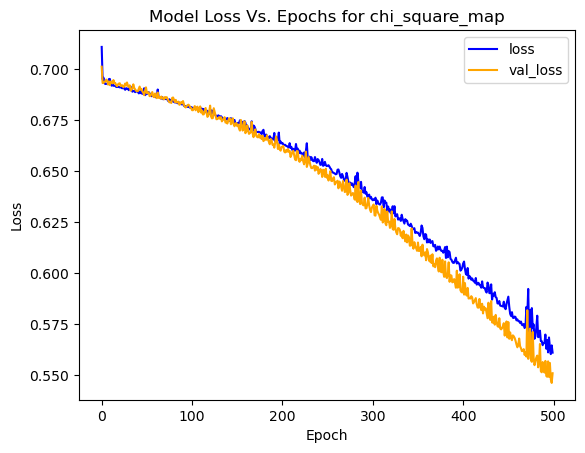

In [17]:
plt.plot(history.history['loss'],'b-')
plt.plot(history.history['val_loss'],'orange')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Model Loss Vs. Epochs for {data_fol}')
plt.show()

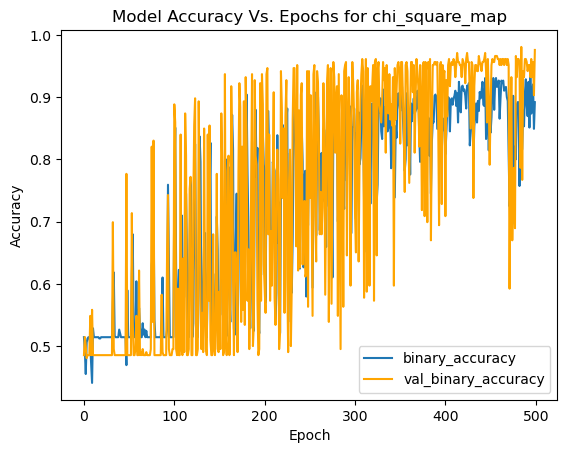

In [18]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'],'orange')
plt.legend(['binary_accuracy', 'val_binary_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Model Accuracy Vs. Epochs for {data_fol}')
plt.show()

In [19]:
# Obtain predictions on the test data
preds = resnet_model.predict(test)

5/5 [==============================] - 1s 26ms/step


In [20]:
# Obtain actual labels
actual_preds = []
for i in preds:
    actual_preds.append(np.argmax(i))

actual_preds = np.array(actual_preds)

In [21]:
# Obtain prediction accuracy on test data
actual_preds = to_categorical(actual_preds, num_classes=n_classes)
sum(actual_preds[:,1] == test_labels[:,1])/len(test_labels[:,1])

0.9054054054054054

Subsequent iterations are inconsistent in their loss and accuracy curves which may be due to the small available sample space of transient data. For the chi square map data, the network's accuracy ranges from approximately 50% to 90%. Out of all three types of maps, it appears that the chi square maps lead to the lowest loss and highest accuracies. Even combining chi square maps with peak maps and standard deviation maps may lead to a lower accuracy than solely using chi square maps for the classifier. 

However it may still be worth to see how the losses and accuracies change after a larger amount of transient data is available and is fed into the network.

# Save The Model and HyperParams

In [22]:
# Save the model weights
fpath = "Models/CSM_Resnet"
resnet_model.save_weights(f"{fpath}/weights.h5")

In [23]:
import pickle

# Save the hyperparameters
with open(f"{fpath}/hyperparams.pkl", "wb") as f:
    pickle.dump(hp_dict, f)